In [82]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer, KBinsDiscretizer, LabelEncoder, MinMaxScaler, PowerTransformer

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use("ggplot")      
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



In [83]:
# 数据读取，删除无效列

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test1.csv')

train.drop(['Unnamed: 0'],axis=1,inplace=True)
test.drop(['Unnamed: 0'],axis=1,inplace=True)
train.head()

# from pandas_profiling import ProfileReport
# ProfileReport(train).to_notebook_iframe()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,os,osv,package,sid,timestamp,version,fea_hash,location,fea1_hash,cus_type
0,316361,1199,46000.0,0.0,0.0,0.0,1,NaN,104,6.0,android,9,18,1438873,1.559893e+12,8,2135019403,0,2329670524,601
1,135939,893,0.0,0.0,0.0,0.0,1,NaN,19,6.0,android,8.1,0,1185582,1.559994e+12,4,2782306428,1,2864801071,1000
2,399254,821,0.0,760.0,0.0,360.0,1,NaN,559,0.0,android,8.1.0,0,1555716,1.559837e+12,0,1392806005,2,628911675,696
3,68983,1004,46000.0,2214.0,0.0,1080.0,0,NaN,129,2.0,android,8.1.0,0,1093419,1.560042e+12,0,3562553457,3,1283809327,753
4,288999,1076,46000.0,2280.0,0.0,1080.0,1,zh-CN,64,2.0,android,8.0.0,0,1400089,1.559867e+12,5,2364522023,4,1510695983,582


In [84]:
train.describe()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,media_id,ntt,package,sid,timestamp,location,fea1_hash,cus_type
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.00000,500000.000000,500000.000000,5.000000e+05,5.000000e+05,500000.000000,5.000000e+05,500000.000000
mean,261359.275126,986.640110,40028.788034,1264.986626,72.027966,703.486166,0.48448,124.08762,3.089808,38.465876,1.500335e+06,1.559814e+12,96.040504,2.300866e+09,730.824682
std,233616.172774,128.956348,15460.788899,853.371330,167.664930,505.751343,0.49976,164.25454,1.843088,136.321129,2.884292e+05,1.680735e+08,85.652740,1.236593e+09,331.946854
min,0.000000,95.000000,-1.000000,0.000000,0.000000,0.000000,0.00000,4.00000,0.000000,0.000000,1.000005e+06,1.559491e+12,-1.000000,1.240000e+04,297.000000
25%,0.000000,917.000000,46000.000000,720.000000,0.000000,360.000000,0.00000,29.00000,2.000000,0.000000,1.250850e+06,1.559664e+12,23.000000,1.376752e+09,411.000000
50%,228563.000000,1001.000000,46000.000000,1280.000000,0.000000,720.000000,0.00000,64.00000,2.000000,7.000000,1.500358e+06,1.559816e+12,64.000000,2.490131e+09,658.000000
75%,465701.500000,1076.000000,46000.000000,2040.000000,0.000000,1080.000000,1.00000,139.00000,5.000000,24.000000,1.750028e+06,1.559964e+12,154.000000,3.062465e+09,1019.000000
max,709898.000000,1241.000000,46003.000000,9024.000000,720.000000,8832.000000,1.00000,1544.00000,7.000000,2327.000000,1.999999e+06,1.560096e+12,330.000000,4.291920e+09,1380.000000


In [85]:
train.dtypes,len(train.columns)-1

(android_id      int64
 apptype         int64
 carrier       float64
 dev_height    float64
 dev_ppi       float64
 dev_width     float64
 label           int64
 lan            object
 media_id        int64
 ntt           float64
 os             object
 osv            object
 package         int64
 sid             int64
 timestamp     float64
 version        object
 fea_hash       object
 location        int64
 fea1_hash       int64
 cus_type        int64
 dtype: object,
 19)

In [86]:
# 把各个特征的分布都用直方图画一下(除了fea_hash、fea1_hash、label)

# fea_plt = train.columns.tolist()
# fea_plt.remove('label')
# fea_plt.remove('fea_hash')
# fea_plt.remove('fea1_hash')

# for i in range(len(fea_plt)):
#     print('{}'.format(fea_plt[i]))
#     train[fea_plt[i]].hist()
#     plt.show();
# print(i)    



# plt.figure()
# fig, axs = plt.subplots(4, 5, figsize=(18, 6))

# n = 0
# for i in range(4):
#     x=0
#     for j in range(5):   
#         axs[i][j].hist(train[fea_plt[x+n*5]])
#         axs[i][j].set_title('{}'.format(fea_plt[x+n*5]))
#         x+=1
#     n+=1

# fig.tight_layout();


In [87]:
# plt.figure(figsize=(12, 10))
# sns.heatmap(train.corr(),linewidths = 0.05);

# # 少了fea_hash，发现这列是str，并且有些奇怪的值
# print('与label的相关性：')
# train.corr().label.sort_values()

In [88]:
# # 特征取值类别
# for col in train.columns:
#     col,train[col].nunique()

特征处理

osv、version、timestamp、fea_hash、fea1_hash

In [89]:
data = pd.concat([train,test])

data.osv.unique()

array(['9', '8.1', '8.1.0', '8.0.0', '5.1', '9.0.0', '7.1.1', '5.1.1',
       '7.8.7', '4.4.4', nan, '6.0', '6.0.1', '3.9.0', 'Android_8.1.0',
       '7.0', '7.9.2', 'Android_9', '7.9.0', '7.1.2', '3.8.6', '5.1.0',
       '9.0', '7.7.7', '6.0.0', '5.0.2', 'Android_6.0.1', '7.0.0',
       '6.0_23', '4.2.2', '7.1', '8.0', '4.3', 'Android_8.0.0', '4.4.2',
       '4.1', 'Android_7.1.1', '5.0', 'Android_5.1.1', '2.3', '5.0.0',
       '7.8.0', '5.0.1', '4.4', '7.8.6', 'Android_5.1', 'Android_7.1.2',
       'Android_4.4.4', '8.0.1', '3.1.1', '7.7.2', '6.1', '3.8.4',
       '7.8.9', '7.7.5', '7.6.8', 'Android_7.0', '7.8.4', '7', '7.7.3',
       '7.1.0', '9.1', '4.1.1', 'Android_4.4.2', '3.8.0', '6.1.2',
       '7.2.1', '7.6.9', '3.7.8', '7.8.2', '8', '7910', '7.6.4', '7.8.5',
       '2.2.3', '5.2', 'Android_6.0', '4.2.1', '10.3.3', '4.0.2', '7.8.8',
       '4.4.3', '21100', '7.7.0', '4.0.3', '4.0.4', '5', '2.3.6', '6.1.0',
       '21000', '4.3.0', '4.1.2', '4.2', '7.6.7', '9.0.5', '4.4.2_19',


In [90]:
# 处理osv字段，把非数字的转为数字

def handle_osv(osv):
    osv = str(osv).replace('.','').replace('W','').replace('Android_','').replace('Android', '').replace('十核20G_HD', '').replace(' ','')
    if osv=='nan' or osv=='GIONEE_YNGA': # 这2个值的前面的取值都为8.1.0
        result = 810
    elif osv=='f073b_changxiang_v01_b1b8_20180915':
        result = 810
    elif osv=='%E6%B1%9F%E7%81%B5OS+50':
        result=500
    elif osv.count('-')>0:
        result = int(osv.split('-')[0])
    else:
        result = int(osv)
    
    if result<10:
        result*=100
    elif result<100:
        result*=10
    
    return int(result)



data['osv'] = data['osv'].apply(handle_osv)     


tmp_osv = data[data['label'].notnull()][['osv','label']]
# print('osv大于10000的负样本占比：{}'.format(tmp_osv[(tmp_osv['osv']>10000)&(tmp_osv['label']==1)].shape[0]/tmp_osv[(tmp_osv['osv']>10000)].shape[0]))

data['osv'] = data['osv'].apply(lambda x: 810 if x>10000 else x)
data['osv'].unique()

data.shape[1]

array([ 900,  810,  800,  510,  711,  511,  787,  444,  600,  601,  390,
        700,  792,  790,  712,  386,  777,  502, 6023,  422,  710,  430,
        442,  410,  500,  230,  780,  501,  440,  786,  801,  311,  772,
        610,  384,  789,  775,  768,  784,  773,  910,  411,  380,  612,
        721,  769,  378,  782, 7910,  764,  785,  223,  520,  421, 1033,
        402,  788,  443,  770,  403,  404,  236,  412,  420,  767,  905,
        383,  433,  445,  376,  235,  713,  303,  621, 5122, 7930, 4232,
        512,  774,  602,  431,  237,  530,  212,  766,  234,  320,  110,
        400,  731,  802, 5021,  201,  429, 7920,  503,  292,  222,  446,
        120], dtype=int64)

20

In [91]:
def handle_version(version):
    version = str(version).replace(' ','').replace('v','').replace('V','').replace('GA','').replace('P_Final_','').replace('GA','')
    return int(version)

data['version'] = data['version'].apply(handle_version)
data['version'].unique()

array([ 8,  4,  0,  5,  9,  7,  3,  1,  6, 11,  2, 10, 15, 50, 20],
      dtype=int64)

In [92]:
# 训练集中没有的version 为20 ；
# 在测试集中version=20的数据 只有1条，不影响

set(data['version'].unique()) - set(data[data['label'].notnull()][['version','label']]['version'].unique())

{20}

50    1.000000
15    0.777778
7     0.768563
5     0.676263
2     0.583059
8     0.513273
6     0.495004
1     0.467586
0     0.459799
11    0.445585
3     0.281845
10    0.206349
4     0.203693
9     0.177778
Name: label=1的样本占比, dtype: float64

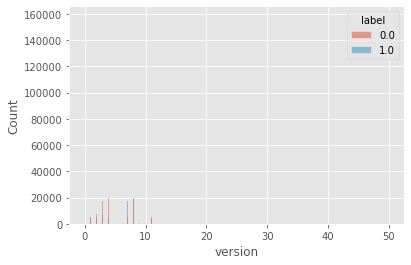

In [93]:
def dispersed_fea_labelratio(data,feature,label):
    '''离散特征label=1的占比'''
    result=[]
    for fea in data[feature].unique().tolist():
        result_ratio = data[(data[feature]==fea)&(data[label]==1)].shape[0]/data[(data[feature]==fea)].shape[0]
        result.append(result_ratio)
        # print('{0}={1}负样本占比：{2}'.format(feature,fea,result_ratio))

    sns.histplot(data=data[[feature,label]],x=feature,hue=label)

    return pd.Series(result,index=data[feature].unique().tolist(),name='label=1的样本占比').sort_values(ascending=False)



dispersed_fea_labelratio( data[data['label'].notnull()],'version','label')

In [94]:
# lan缺失值比例高达36%，可考虑采用 树模型 预测填充

tmp_lan = data.drop(['label'],axis=1)
lan_null = tmp_lan[tmp_lan['lan'].isnull()]
print('lan缺失占比：{}'.format(lan_null.shape[0]/tmp_lan.shape[0]))

lan缺失占比：0.36742615384615385


In [95]:
import datetime
data['timestamp'] = data['timestamp'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000))

data['year']= data['timestamp'].dt.year
data['month']= data['timestamp'].dt.month
data['day']= data['timestamp'].dt.day
data['hour']= data['timestamp'].dt.hour
data['minute']= data['timestamp'].dt.minute
data['weekday']= data['timestamp'].dt.weekday

# 划分 训练集

train = data[data['label'].notnull()]
test = data[data['label'].isnull()].drop(['label'],axis=1)
train.columns

# 获取time_diff
start_time1 = train['timestamp'].min()
train['timestamp_diff'] = train['timestamp']-start_time1
train['timestamp_diff'] = train['timestamp_diff'].dt.days - train['timestamp_diff'].dt.seconds/3600/24

start_time2 = test['timestamp'].min()
test['timestamp_diff'] = test['timestamp']-start_time2
test['timestamp_diff'] = test['timestamp_diff'].dt.days - test['timestamp_diff'].dt.seconds/3600/24

data = pd.concat([train,test])
data.shape

Index(['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'label', 'lan', 'media_id', 'ntt', 'os', 'osv', 'package',
       'sid', 'timestamp', 'version', 'fea_hash', 'location', 'fea1_hash',
       'cus_type', 'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

(650000, 27)

In [96]:
# fea_hash 有5w多个不同的取值,大多数就10位，大于10位的就处理成-1

train['fea_hash'].apply(len).quantile([.1,.2,.5,.75,.95])

data['fea_hash'] = data['fea_hash'].map(lambda i:-1 if len(str(i))>10 else int(i))
data['fea_hash_len'] = data['fea_hash'].map(lambda i:len(str(i)))

0.10     9.0
0.20     9.0
0.50    10.0
0.75    10.0
0.95    10.0
Name: fea_hash, dtype: float64

In [97]:
# fea1_hash 大多数就10位，大于10位的就处理成-1

train['fea1_hash'].astype('str').map(len).quantile([.1,.2,.5,.75,.95])

data['fea1_hash'] = data['fea1_hash'].map(lambda i:-1 if len(str(i))>10 else int(i))
data['fea1_hash_len'] = data['fea1_hash'].map(lambda i:len(str(i)))

0.10     9.0
0.20     9.0
0.50    10.0
0.75    10.0
0.95    10.0
Name: fea1_hash, dtype: float64

In [98]:
#  os处理

# data['os'] = LabelEncoder.fit_transform(data.os)

data['osv_ver'] = data['osv'] - data['version']

In [99]:
data.head()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,...,year,month,day,hour,minute,weekday,timestamp_diff,fea_hash_len,fea1_hash_len,osv_ver
0,316361,1199,46000.0,0.0,0.0,0.0,1.0,NaN,104,6.0,...,2019,6,7,15,32,4,3.352697,10,10,892
1,135939,893,0.0,0.0,0.0,0.0,1.0,NaN,19,6.0,...,2019,6,8,19,40,5,4.180336,10,10,806
2,399254,821,0.0,760.0,0.0,360.0,1.0,NaN,559,0.0,...,2019,6,6,23,58,3,2.001204,10,9,810
3,68983,1004,46000.0,2214.0,0.0,1080.0,0.0,NaN,129,2.0,...,2019,6,9,8,59,6,5.625278,10,10,810
4,288999,1076,46000.0,2280.0,0.0,1080.0,1.0,zh-CN,64,2.0,...,2019,6,7,8,28,4,3.646991,10,10,795


In [100]:
feat_cols = ['apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'lan', 'media_id', 'ntt', 'osv', 'package',
       'version', 'fea_hash', 'location', 'fea1_hash',
       'cus_type', 'year', 'month', 'day', 'hour', 'minute', 'weekday',
       'fea_hash_len', 'fea1_hash_len', 'osv_ver', 'timestamp_diff']


In [101]:
## 随机森林/决策树 预测lan缺失值

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

LabelEncoder= LabelEncoder()

lan_train = data[data['lan'].notnull()][feat_cols]
lan_test = data[data['lan'].isnull()][feat_cols]

lan_train_label = data[data['lan'].notnull()]['label']
lan_train_sid = data[data['lan'].notnull()]['sid']
lan_test_label = data[data['lan'].isnull()]['label']
lan_test_sid = data[data['lan'].isnull()]['sid']


X = lan_train.drop(['lan'],axis=1)
y = LabelEncoder.fit_transform(lan_train['lan'].astype('str'))

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0,test_size=0.2)
rf = RandomForestClassifier(random_state=0,n_jobs=-1,n_estimators=2000,max_depth=8)
rf.fit(X_train,y_train)
print(f1_score(y_test,rf.predict(X_test),average='macro'))
lan_pred_label = rf.predict(lan_test.drop(['lan'], axis=1))




# dt_model = RandomForestRegressor(random_state=0,n_estimators=2000,n_jobs=-1)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
# lan_pred_label = []
# mean_acc = 0

# for k,(train_index, test_index) in enumerate(skf.split(X, y)):
#     print(k)
#     X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[test_index]

#     model = dt_model.fit(X_train,y_train)
#     lan_pred = model.predict(lan_test.drop(['lan','label','android_id','timestamp'], axis=1))
#     print(accuracy_score(y_val,model.predict(X_val)))
#     lan_pred_label.append(lan_pred)

# print('训练结束~')

RandomForestClassifier(max_depth=8, n_estimators=2000, n_jobs=-1,
                       random_state=0)

0.3570655365059308


In [102]:
lan_train['lan'] = y
lan_train['sid'] = lan_train_sid
lan_train['label'] = lan_train_label

lan_test['lan'] = lan_pred_label
lan_test['sid'] = lan_test_sid
lan_test['label'] = lan_test_label


data = pd.concat([lan_train,lan_test])


print('参与训练的特征：{0},个数：{1}'.format(set(feat_cols),len(set(feat_cols))))

参与训练的特征：{'cus_type', 'month', 'media_id', 'timestamp_diff', 'carrier', 'location', 'osv_ver', 'year', 'osv', 'ntt', 'lan', 'fea_hash', 'hour', 'day', 'fea1_hash', 'package', 'dev_width', 'apptype', 'fea_hash_len', 'fea1_hash_len', 'minute', 'dev_height', 'version', 'dev_ppi', 'weekday'},个数：25


In [103]:
train = data[data['label'].notnull()].reset_index().drop(['index'],axis=1)
test = data[data['label'].isnull()].reset_index().drop(['index'],axis=1)

## LGB单模

In [104]:
def train_lgb_kfold(X_train, y_train, X_test, n_fold=5):
    '''train lightgbm with k-fold split'''
    gbms = []
    kfold = StratifiedKFold(n_splits=n_fold, random_state=2021, shuffle=True)
    oof_preds = np.zeros((X_train.shape[0],))
    test_preds = np.zeros((X_test.shape[0],))

    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        X_tr, X_val, y_tr, y_val = X_train.iloc[train_index], X_train.iloc[val_index], y_train[train_index], y_train[val_index]
        dtrain = lgb.Dataset(X_tr, y_tr)
        dvalid = lgb.Dataset(X_val, y_val, reference=dtrain)

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'num_leaves': 512,
            'boosting_type':'gbdt',
            'subsample_freq':1,
            'reg_alpha':0.5,
            'reg_lambda':0.5,
            'n_estimators':5000,
            'learning_rate': 0.005,
            'min_data_in_leaf': 150,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.7,
            'n_jobs': -1,
            'seed': 2021
        }

        gbm = lgb.train(params,
                        dtrain,
                        num_boost_round=100,
                        valid_sets=[dtrain, dvalid],
                        verbose_eval=50,
                        early_stopping_rounds=20)

        oof_preds[val_index] = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        test_preds += gbm.predict(X_test, num_iteration=gbm.best_iteration) / kfold.n_splits
        gbms.append(gbm)

    return gbms, oof_preds, test_preds



In [105]:
def train_lgb(train, test, feat_cols, label_col, n_fold=10):
    '''训练lightgbm'''
    X_train = train[feat_cols]
    y_train = train[label_col]
    X_test = test[feat_cols]
    gbms_lgb, oof_preds_lgb, test_preds_lgb = train_lgb_kfold(X_train, y_train, X_test, n_fold=n_fold)
    
    return gbms_lgb, oof_preds_lgb, test_preds_lgb


In [106]:
gbms_lgb, oof_preds_lgb, test_preds_lgb = train_lgb(train, test,
                                                    feat_cols=feat_cols,
                                                    label_col='label')


[LightGBM] [Info] Number of positive: 218016, number of negative: 231984
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484480 -> initscore=-0.062100
[LightGBM] [Info] Start training from score -0.062100
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[26]	training's auc: 0.939386	valid_1's 

In [107]:
def gen_thres_new(df_train, oof_preds):
    df_train['oof_preds'] = oof_preds
    thres = df_train['label'].mean() 
    # thres = df_train['oof_preds'].quantile(1 - quantile_point) # 比如 0,1,1,1 mean=0.75 1-mean=0.25,也就是25%分位数取值为0

    _thresh = []
    for thres_item in np.arange(thres - 0.2, thres + 0.2, 0.01): #  按照理论阈值的上下0.2范围，0.01步长，找到最佳阈值，f1分数最高对应的阈值即为最佳阈值
        _thresh.append(
            [thres_item, f1_score(df_train['label'], np.where(oof_preds > thres_item, 1, 0), average='macro')])

    _thresh = np.array(_thresh)
    best_id = _thresh[:, 1].argmax() # 找到f1最高对应的行
    best_thresh = _thresh[best_id][0] # 取出最佳阈值

    print("阈值: {}\n训练集的f1: {}".format(best_thresh, _thresh[best_id][1]))
    return best_thresh

lgb_thres =  gen_thres_new(train, oof_preds_lgb)
print(lgb_thres)



# 测试集预测结果
df_test_res = pd.DataFrame({'sid': test['sid'],
                            'test_preds_lgb': test_preds_lgb})

## 直接按 0.5 划分
# df_test_res['preds'] =  np.where(df_test_res['test_preds_lgb']>0.5,1,0)


## 按最佳阈值划分
df_test_res['preds'] =  np.where(df_test_res['test_preds_lgb']>lgb_thres,1,0)

df_test_submit = df_test_res.iloc[:,[0,2]].rename(columns={'preds':'label'})

sid_submit = pd.read_csv('./data/test1.csv')[['sid']]
sid_submit = sid_submit.merge(df_test_submit,on='sid',how='left')
sid_submit.to_csv('./result.csv', index=False)
print('预测结果，输出成功~')



阈值: 0.4844800000000002
训练集的f1: 0.8798447045658018
0.4844800000000002
预测结果，输出成功~


In [108]:

# # 按分位数 ，划分阈值

# def gen_thres_new(df_train, oof_preds):
#     df_train['oof_preds'] = oof_preds
#     quantile_point = df_train['label'].mean() 
#     thres = df_train['oof_preds'].quantile(1 - quantile_point) # 比如 0,1,1,1 mean=0.75 1-mean=0.25,也就是25%分位数取值为0

#     _thresh = []
#     for thres_item in np.arange(thres - 0.2, thres + 0.2, 0.01): #  按照理论阈值的上下0.2范围，0.01步长，找到最佳阈值，f1分数最高对应的阈值即为最佳阈值
#         _thresh.append(
#             [thres_item, f1_score(df_train['label'], np.where(oof_preds > thres_item, 1, 0), average='macro')])

#     _thresh = np.array(_thresh)
#     best_id = _thresh[:, 1].argmax() # 找到f1最高对应的行
#     best_thresh = _thresh[best_id][0] # 取出最佳阈值

#     print("阈值: {}\n训练集的f1: {}".format(best_thresh, _thresh[best_id][1]))
#     return best_thresh

In [109]:
# lgb_thres =  gen_thres_new(train, oof_preds_lgb)

阈值: 0.4844800000000002
训练集的f1: 0.8798447045658018


In [110]:

# def gen_submit_file(df_test, test_preds, thres, save_path):
#     df_test['test_preds_binary'] = np.where(test_preds > thres, 1, 0)  
#     df_test_submit = df_test[['sid', 'test_preds_binary']]
#     df_test_submit.columns = ['sid', 'label']
#     print(f'saving result to: {save_path}')
#     df_test_submit.to_csv(save_path, index=False)
#     print('done!')
#     return df_test_submit



# df_test_res = pd.DataFrame({'sid': test['sid'],
#                                 'test_preds_lgb': test_preds_lgb})

# df_test_res['lgb_rank'] = df_test_res['test_preds_lgb'].rank(pct=True)
# df_test_res['preds'] =  np.where(df_test_res['lgb_rank']>lgb_thres,1,0)

# # 结果产出
# df_submit = gen_submit_file(df_test_res, df_test_res['preds'], lgb_thres,
#                             save_path='./result.csv')